<a href="https://colab.research.google.com/github/mokarramis/ML-TextClassification/blob/main/LPClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

(38, 17, 3)


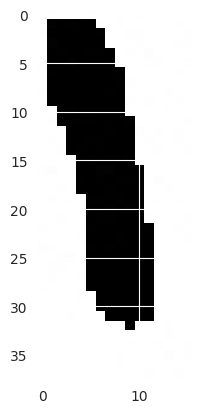

In [3]:
#input an image
fpath=r'/content/drive/MyDrive/large-dataset-of-persian-license-plate-characters/chars/1/2/10067.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [4]:
sdir=r'/content/drive/MyDrive/large-dataset-of-persian-license-plate-characters/chars'

classlist=os.listdir(sdir)
filepaths=[]
labels=[]
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    twopath=os.path.join(classpath,'2')
    flist=os.listdir(twopath)
    print(klass)
    for f in flist:
        fpath=os.path.join(twopath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
trsplit=.9
vsplit=.05
dsplit=vsplit/(1-trsplit)
train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123)
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
balance=list(train_df['labels'].value_counts())
print (df.head())
for b in balance:
    print (b)

7
1
9
5
6
3
2
8
4
A
J
M
L
H
N
E
G
C
D
B
V
Y
S
T
train_df length:  18483   test_df length:  1027   valid_df length:  1027
                                           filepaths labels
0  /content/drive/MyDrive/large-dataset-of-persia...      7
1  /content/drive/MyDrive/large-dataset-of-persia...      7
2  /content/drive/MyDrive/large-dataset-of-persia...      7
3  /content/drive/MyDrive/large-dataset-of-persia...      7
4  /content/drive/MyDrive/large-dataset-of-persia...      7
1830
1650
1441
1385
1312
1294
1219
1211
1161
897
821
539
492
480
460
351
344
326
278
269
208
195
165
155


In [5]:
#train_df length:  18133   test_df length:  1008   valid_df length:  1007

#this is a unbalanced data set for train_df, limit maximum number of samples in a class to 300
sample_list=[]
max_size= 380
min_size =0
groups=train_df.groupby('labels')
for label in train_df['labels'].unique():
    group=groups.get_group(label)
    sample_count=len(group)
    if sample_count> max_size :
        samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
        sample_list.append(samples)
    elif sample_count>= min_size:
        sample_list.append(group)
train_df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(train_df))
print (train_df['labels'].value_counts())

7991
T    380
1    380
D    380
J    380
7    380
6    380
3    380
A    380
8    380
G    380
2    380
4    380
5    380
9    380
B    380
C    351
V    344
M    326
Y    278
L    269
H    208
S    195
N    165
E    155
Name: labels, dtype: int64


In [6]:

#create train, test, valid generators
height=76
width=34
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    #img=img/127.5-1
    return img
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
#sdir=r'../input/mars-surface-and-curiosity-image-set-nasa/Mars Surface and Curiosity Image/images'
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  79   test steps:  13
Found 7990 validated image filenames belonging to 24 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 1026 validated image filenames belonging to 24 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 1027 validated image filenames belonging to 24 classes.


In [111]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

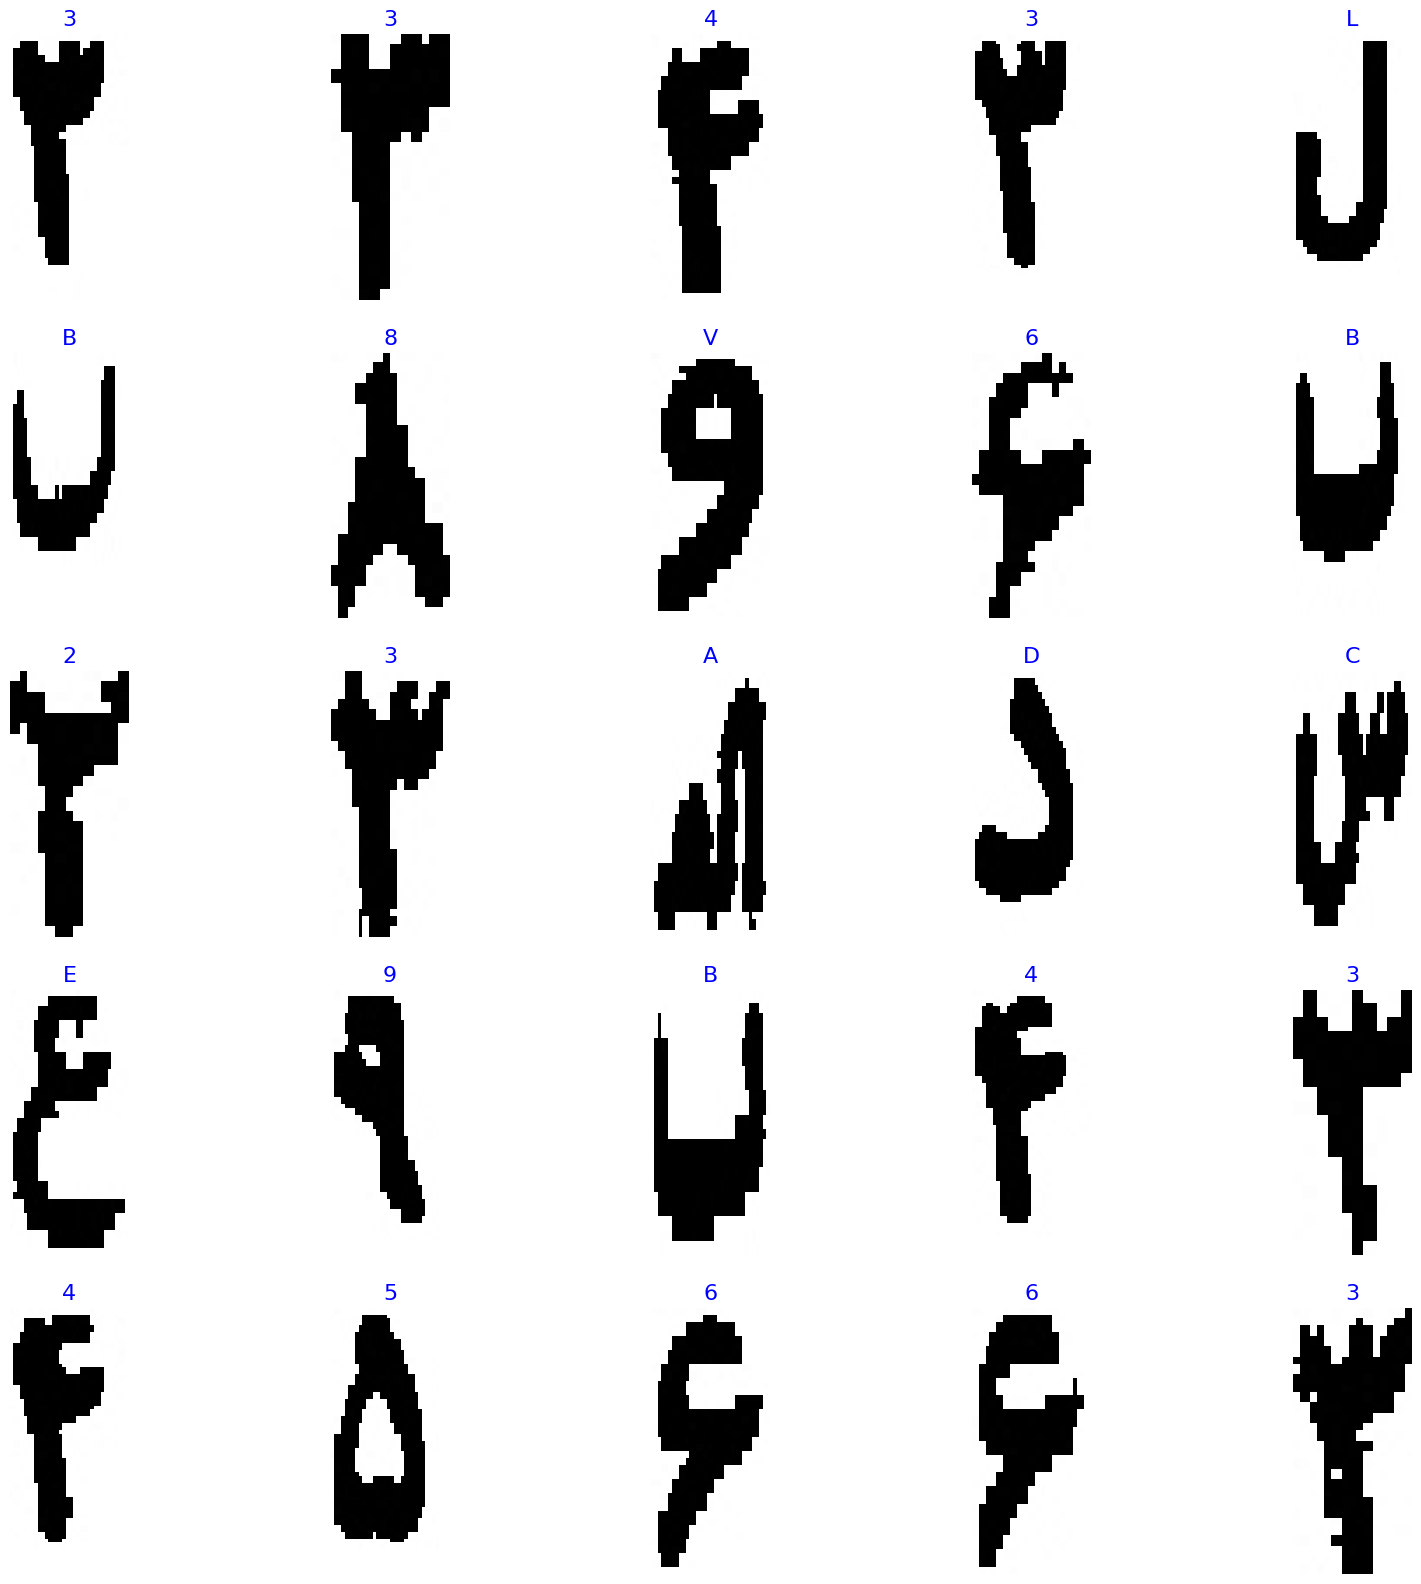

In [8]:
show_image_samples(test_gen)

In [9]:
#define function to print text in RGB foreground and background colors
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [10]:
#create the model
model_name='EfficientNetB1'
base_model=tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:

# Downloading data from https://storage.googleapis.com/keras-applications/efficientnetb1_notop.h5
# 27025408/27018416 [==============================] - 0s 0us/step
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0

    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.initial_epoch=initial_epoch
        self.batches=batches
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '
        print_in_color (msgs, (244, 252, 3), (55,65,80))
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
    def on_train_end(self, logs=None):
        model.set_weights(LRA.best_weights)
        msg='Training is completed - model is set with weights for the epoch with the lowest loss'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count


    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will coninue until epoch ' + str(self.ask_epoch)
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))

In [12]:
#instantiate the custom callback and train the model
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model EfficientNetB1 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 1 /40     7.001   77.785   5.10216  93.768   0.00100  0.00100  accuracy  2274.82 

 2 /40     3.936   97.422   2.91724  99.416   0.00100  0.00100  val_loss   23.10  

 3 /40     2.318   98.874   1.66923  99.903   0.00100  0.00100  val_loss   23.19  

 4 /40     1.363   99.324   0.97297  100.000  0.00100  0.00100  val_loss   22.83  

 5 /40     0.831   99.399   0.60659  100.000  0.00100  0.00100  val_loss   24.92  

enter H to halt training or an integer for number of epochs to run then ask again

20
 training will coninue until epoch 25

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration

 6 /40     0.557   99.675   0.42522  100.000  0.00100  0.00100  val_loss   23.45  

 7 /40     0.433   99.662   0.34383  99.903   0.00100  0.00100  val_loss   25.69  

 8 /40     0.365   99.775   0.29712  100.000  0.

In [13]:
#define function to plot the training data
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [14]:
#define function to generate the confusion matrix and classification report
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

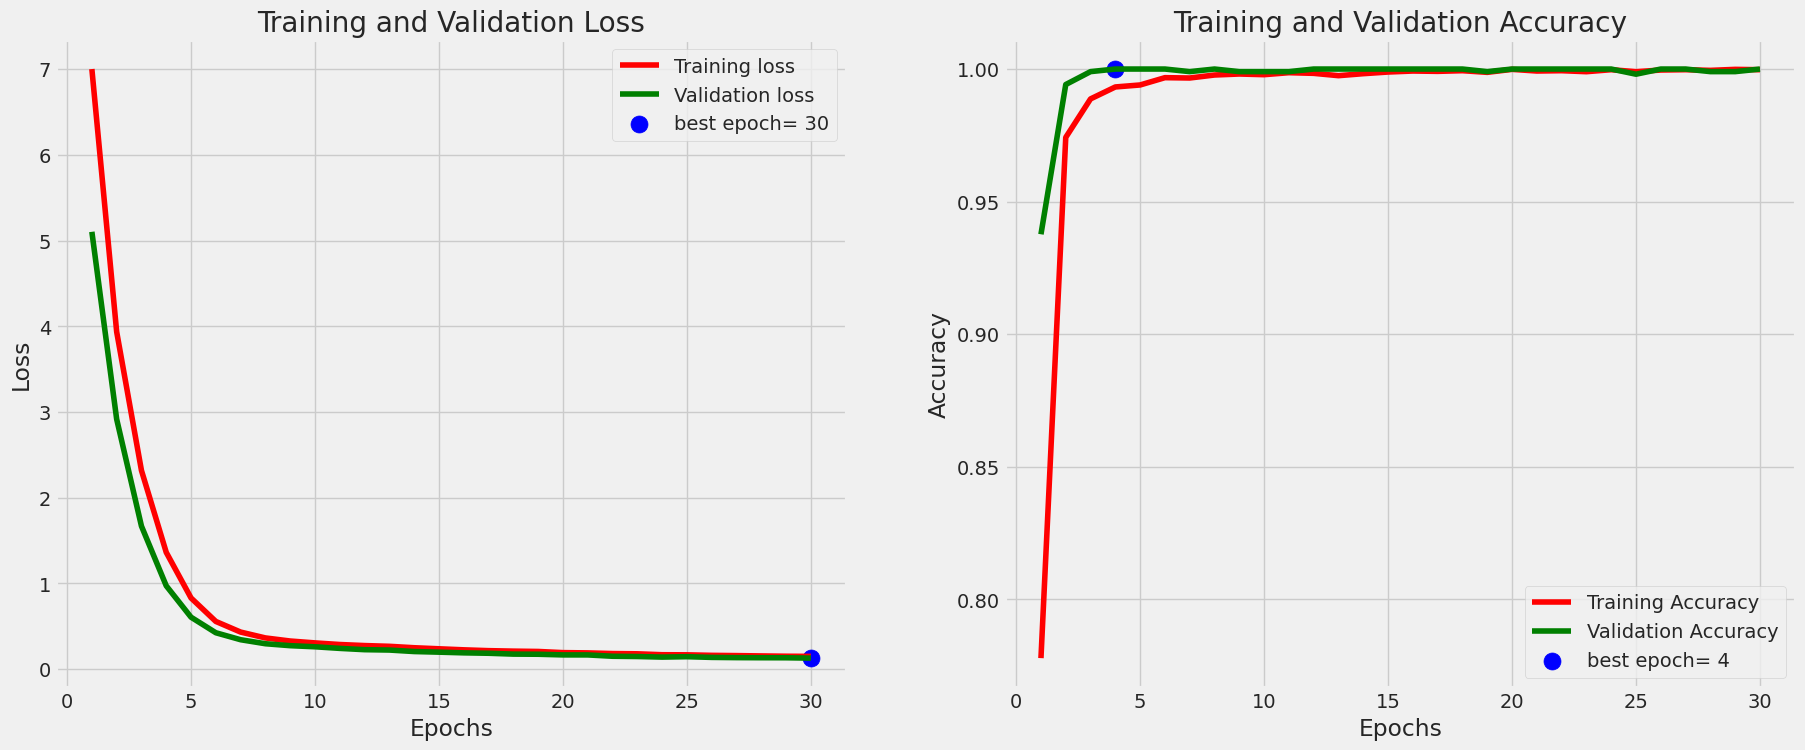

13/13 [==============================] - 380s 32s/step - loss: 0.1343 - accuracy: 0.9990
accuracy on the test set is 99.90 %



TypeError: ignored

In [15]:
#evaluate model on the test set then save the model
tr_plot(history,0)
save_dir=r'./'
subject='apples'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
# model.save("/content/drive/MyDrive")
# # make predictions on test set and generate confusion matrix and classification report
# print_code=0
# preds=model.predict(test_gen)
# print_info( test_gen, preds, print_code, save_dir, subject )
# fpath='../input/plateiran/index.jpg'
# img=plt.imread(fpath)
# print (img.shape)
# imshow(img)
#کد تشخیص حروف روی پلاک
#https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
#https://www.tensorflow.org/tutorials/images/classification

13/13 [==============================] - 7s 128ms/step


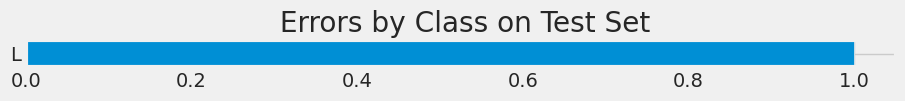

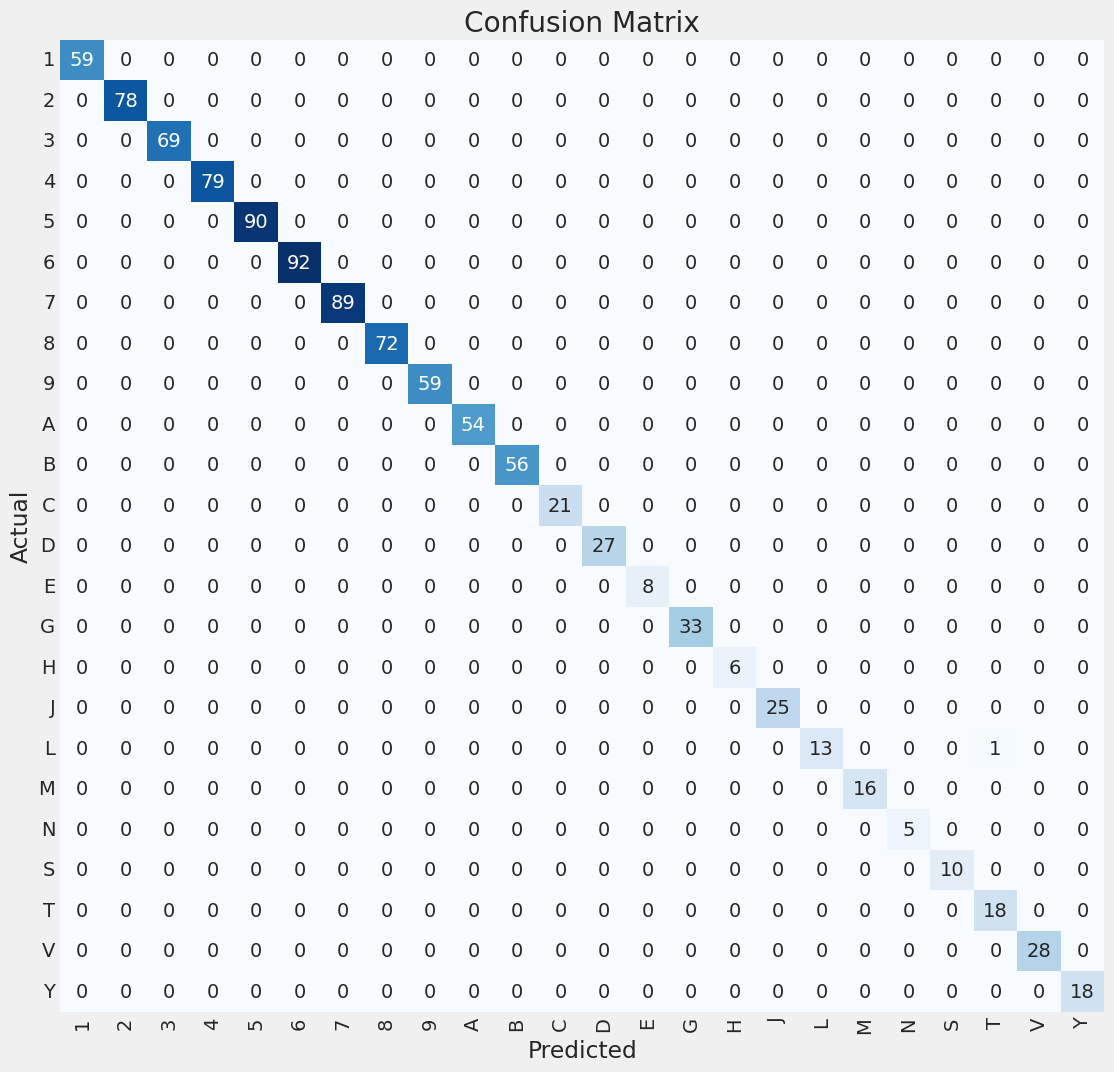

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        59
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        69
           4       1.00      1.00      1.00        79
           5       1.00      1.00      1.00        90
           6       1.00      1.00      1.00        92
           7       1.00      1.00      1.00        89
           8       1.00      1.00      1.00        72
           9       1.00      1.00      1.00        59
           A       1.00      1.00      1.00        54
           B       1.00      1.00      1.00        56
           C       1.00      1.00      1.00        21
           D       1.00      1.00      1.00        27
           E       1.00      1.00      1.00         8
           G       1.00      1.00      1.00        33
           H       1.00      1.00      1.00         6
           J       1.00      1.00 

In [18]:
# model.save("/content/drive/MyDrive/large-dataset-of-persian-license-plate-characters", include_optimizer=False)
# make predictions on test set and generate confusion matrix and classification report
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )
# fpath='../input/plateiran/index.jpg'
# img=plt.imread(fpath)
# print (img.shape)
# imshow(img)

In [38]:
print(preds)

[[6.2016145e-05 2.6491919e-04 9.9766552e-01 ... 1.0104975e-04
  4.6586221e-05 1.1177234e-04]
 [1.1407674e-04 4.4256746e-04 9.9593496e-01 ... 1.7834728e-04
  9.0897185e-05 1.9647148e-04]
 [1.8923474e-04 3.8647387e-04 7.2163658e-04 ... 2.4772360e-04
  2.5941085e-04 1.7616696e-04]
 ...
 [1.5054560e-04 2.1409742e-04 1.3689409e-04 ... 5.9134920e-05
  5.9261154e-05 1.2749714e-04]
 [2.9383265e-04 3.6523107e-04 3.5688997e-04 ... 3.2844523e-04
  2.3451286e-04 2.2964425e-04]
 [2.1931554e-04 2.6137300e-04 1.8221492e-04 ... 1.4635293e-04
  9.4116986e-05 1.9266208e-04]]


In [49]:
total = (np.argmax(preds, axis=1))

In [50]:
total

array([ 2,  2,  3, ...,  6, 18,  7])

In [51]:
total.shape

(1026,)

In [81]:
total[4]

17

In [39]:
print(len(preds))

1026


In [45]:
print(preds.shape)

(1026, 24)


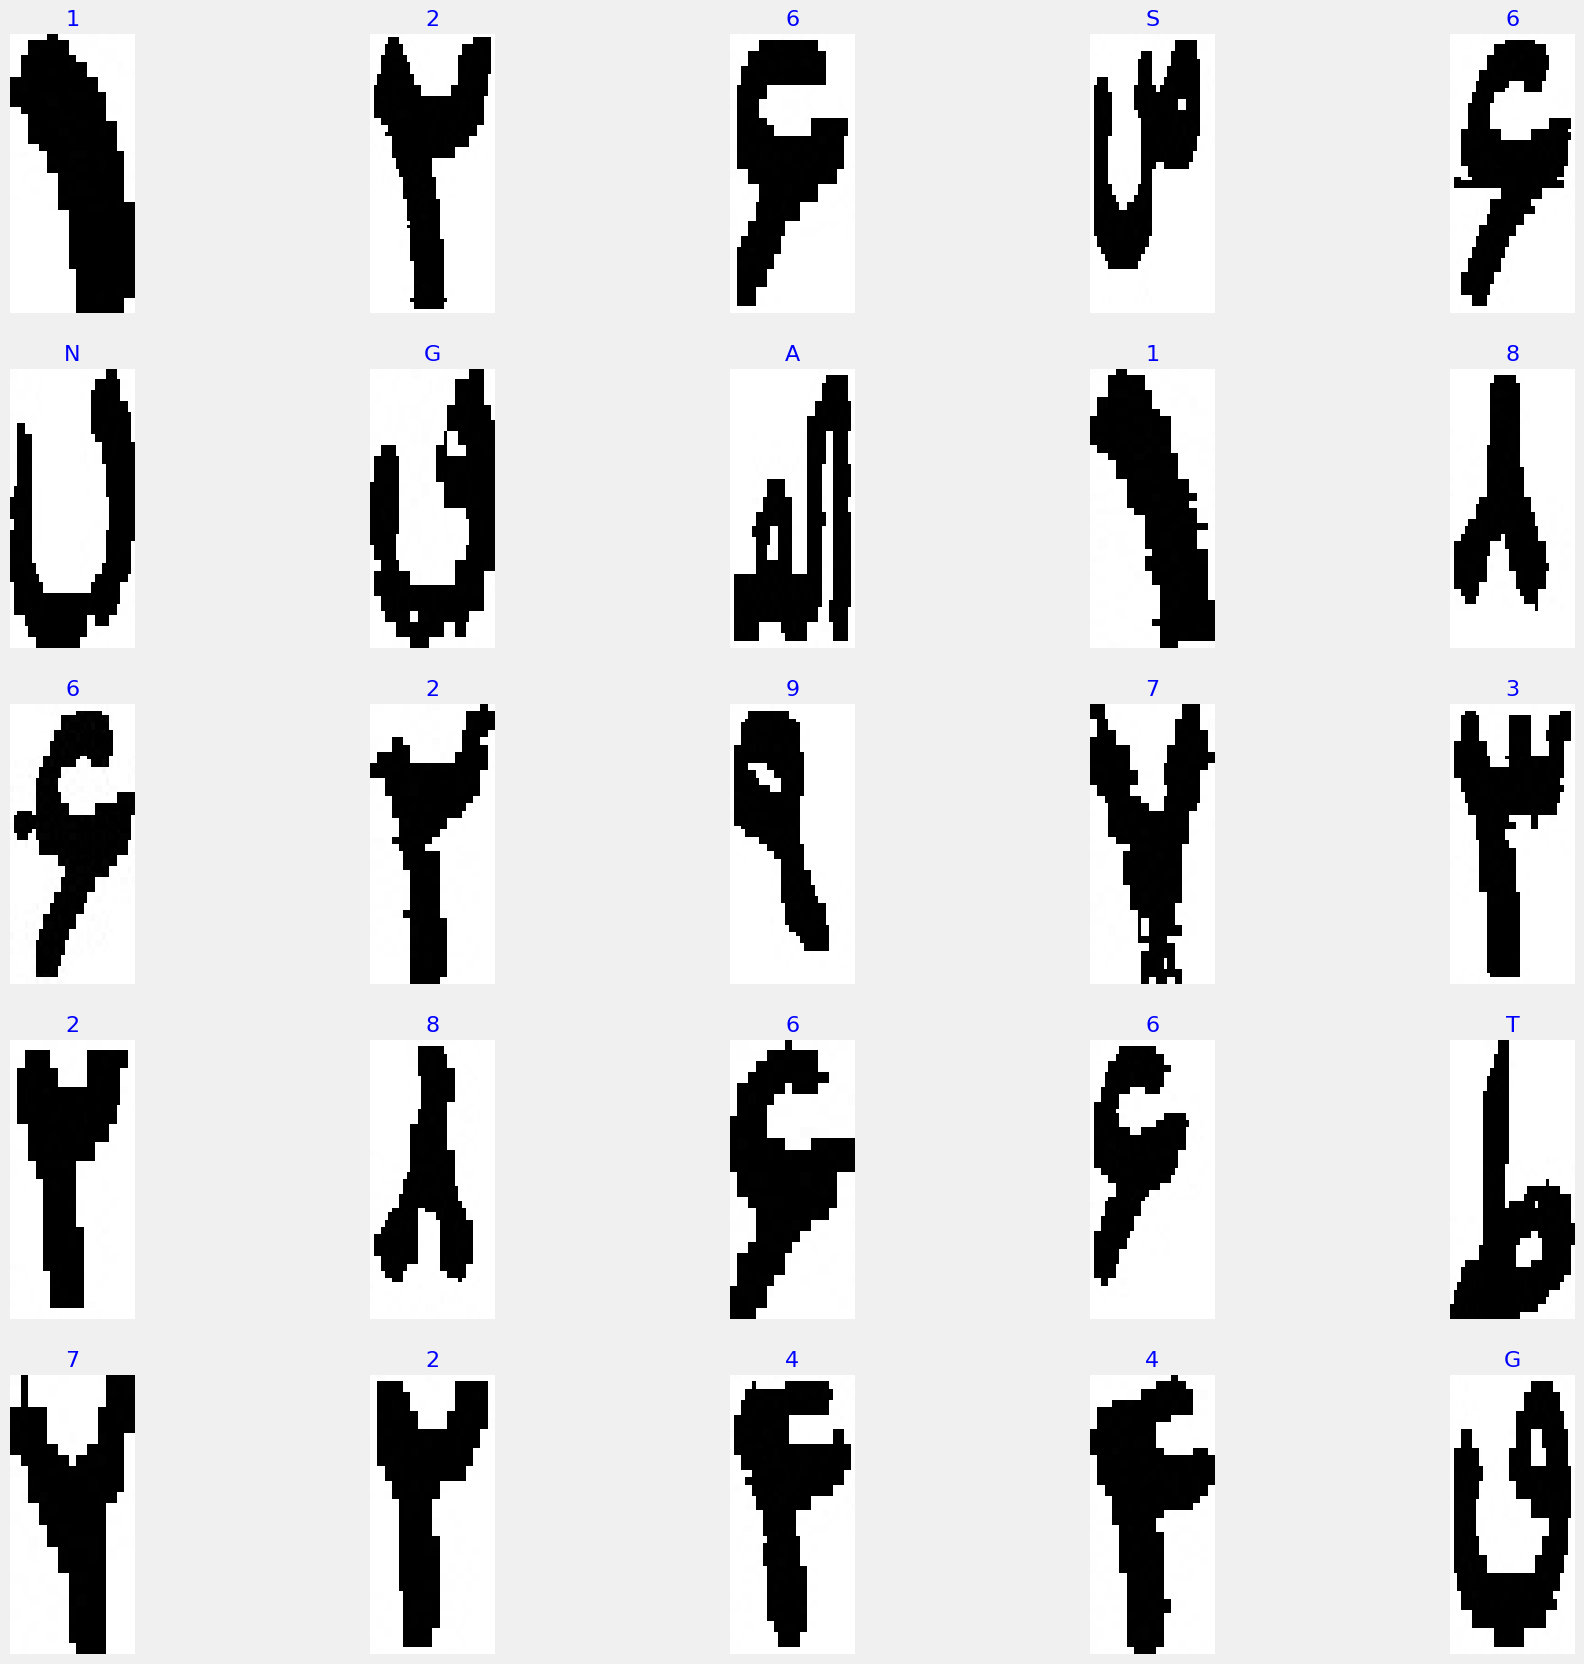

In [25]:
show_image_samples(test_gen)

In [86]:
test_gen.class_indices

{'1': 0,
 '2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 '9': 8,
 'A': 9,
 'B': 10,
 'C': 11,
 'D': 12,
 'E': 13,
 'G': 14,
 'H': 15,
 'J': 16,
 'L': 17,
 'M': 18,
 'N': 19,
 'S': 20,
 'T': 21,
 'V': 22,
 'Y': 23}

In [108]:
# predicted values
y_pred_enc = model.predict(test_gen)

# decoding predicted values
y_pred = [np.argmax(i) for i in y_pred_enc]

print(y_pred_enc[2])
print(y_pred)

13/13 [==============================] - 2s 128ms/step
[1.8923474e-04 3.8647387e-04 7.2163658e-04 9.9426478e-01 2.1166100e-04
 3.5386794e-04 2.4853877e-04 1.8403883e-04 2.8279159e-04 1.5350089e-04
 9.8289100e-05 3.1063915e-04 2.8048950e-04 2.0844727e-04 1.8532295e-04
 2.1701539e-04 2.8200090e-04 1.1373000e-04 1.0816515e-04 3.3460118e-04
 1.8149616e-04 2.4772360e-04 2.5941085e-04 1.7616696e-04]
[2, 2, 3, 2, 17, 10, 7, 22, 5, 10, 1, 2, 9, 12, 11, 13, 8, 10, 3, 2, 3, 4, 5, 5, 2, 4, 0, 11, 4, 23, 2, 6, 9, 9, 4, 8, 6, 7, 9, 10, 22, 18, 21, 10, 6, 23, 8, 18, 6, 3, 4, 3, 1, 2, 21, 1, 8, 3, 8, 5, 3, 7, 16, 1, 4, 1, 11, 4, 4, 8, 15, 12, 21, 7, 7, 7, 10, 8, 22, 0, 1, 5, 20, 5, 19, 14, 9, 0, 7, 5, 1, 8, 6, 2, 1, 7, 5, 5, 21, 6, 1, 3, 3, 14, 4, 6, 9, 1, 6, 0, 5, 18, 5, 2, 5, 8, 8, 4, 7, 7, 6, 16, 14, 6, 2, 10, 7, 20, 18, 3, 6, 16, 3, 11, 7, 10, 8, 16, 4, 1, 6, 6, 3, 4, 4, 9, 4, 2, 7, 3, 21, 6, 0, 4, 4, 5, 8, 23, 2, 2, 20, 22, 1, 18, 17, 3, 4, 7, 23, 14, 22, 6, 10, 6, 6, 7, 6, 2, 1, 8, 7, 6, 5, 11,

In [117]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=(gen)[0] # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

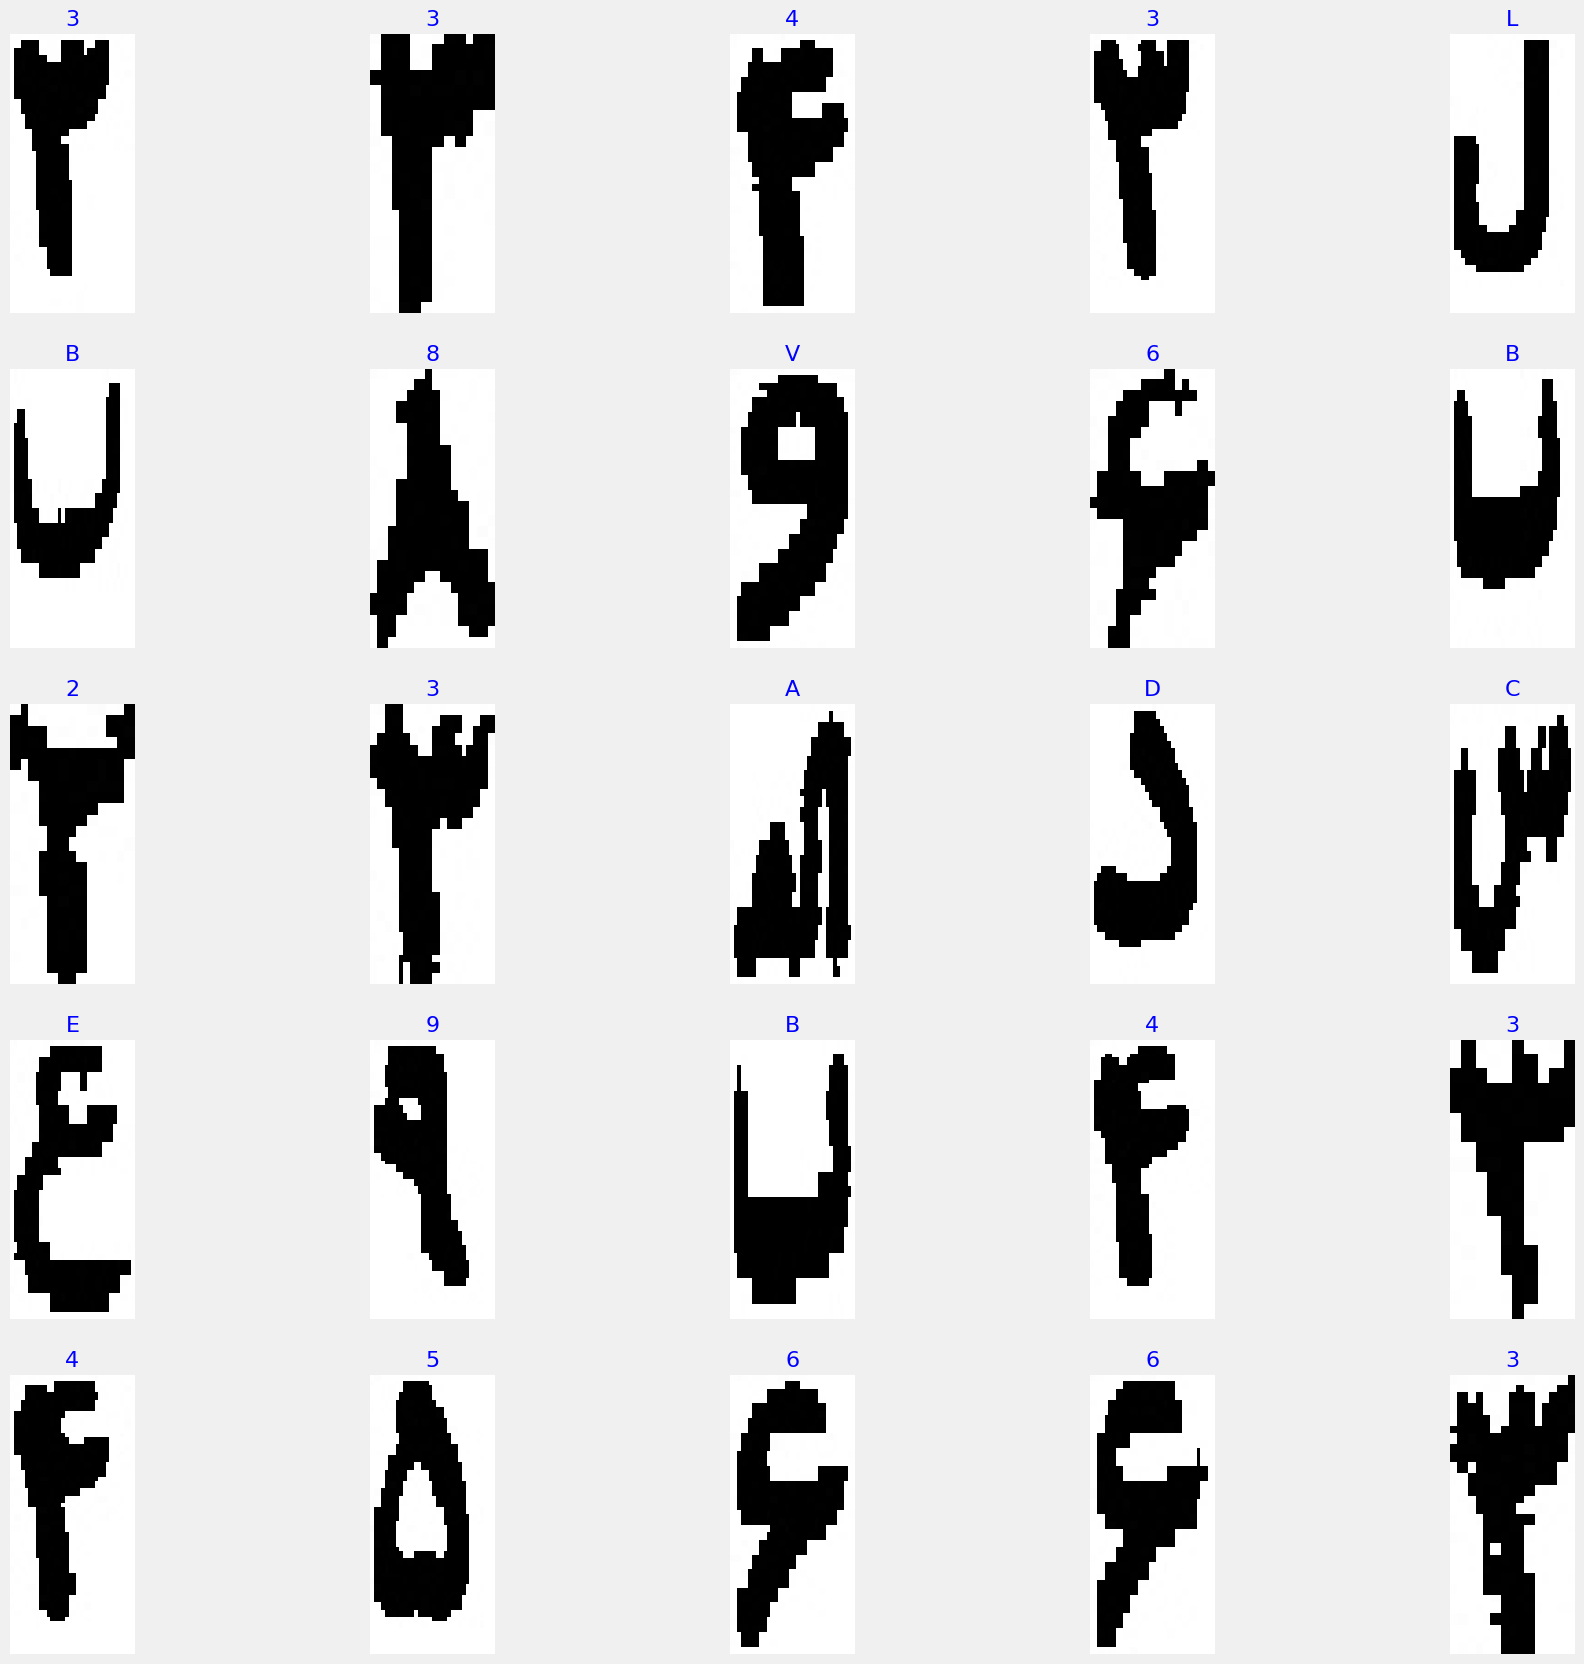

In [119]:
show_image_samples(test_gen)

In [105]:
print(len(y_pred))

1026
